<a href="https://colab.research.google.com/github/AtSourav/AE-n-VAE-with-CB-loss-on-stl10/blob/main/AE_cifar10_mse_HeNormal_L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow import math
import tensorflow_datasets as tfds
from keras import losses
from keras import layers
from keras import utils
from keras import backend as K
from keras import initializers

import os
import random
import matplotlib.pyplot as plt

In [2]:
img_ht = 32
img_wd = 32

input_size = (img_ht,img_wd,3)
latent_dim = 200
batch_size = 128

initializer = initializers.HeNormal(seed=100)

In [3]:
ds = tfds.load('cifar10', split='train')
ds2= tfds.load('cifar10', split='test')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVJD1T2/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVJD1T2/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
ds_to_np = list(ds.as_numpy_iterator())
ds2_to_np = list(ds2.as_numpy_iterator())

In [6]:
img_train = np.array([x['image'] for x in ds_to_np])
img_valid = np.array([x['image'] for x in ds2_to_np])

img_train = img_train/255
img_valid = img_valid/255

In [7]:
encoder_input = keras.Input(shape=input_size)

x = layers.Conv2D(64, 3, padding="valid", kernel_initializer=initializer)(encoder_input)
x = layers.ReLU()(x)

x = layers.Conv2D(64, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(128, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(256, 1, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 2, padding="valid", kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2D(512, 1, padding="valid", kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Flatten()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*latent_dim)(x)
x = layers.ReLU()(x)


z = layers.Dense(latent_dim, name="z")(x)

encoder = keras.Model(encoder_input, z, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 30, 30, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        16448     
                                                                 
 re_lu_1 (ReLU)              (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                           

In [8]:
latent_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(2*latent_dim)(latent_input)
x = layers.ReLU()(x)

x = layers.Dense(3*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(4*latent_dim)(x)
x = layers.ReLU()(x)

x = layers.Dense(2*2*1024)(x)
x = layers.ReLU()(x)

x = layers.Reshape((2,2,1024))(x)

x = layers.Conv2DTranspose(1024, 1, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(512, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

#x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
#x = layers.BatchNormalization(axis=-1)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(256, 3, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(128, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.Conv2DTranspose(64, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

x = layers.UpSampling2D(size=(2, 2), data_format=None, interpolation='bilinear')(x)

x = layers.Conv2DTranspose(8, 2, padding='valid', kernel_initializer=initializer)(x)
x = layers.ReLU()(x)

decoder_output = layers.Conv2DTranspose(3, 2, activation='sigmoid', padding='valid', kernel_initializer=initializer)(x)

decoder = keras.Model(latent_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_2 (Dense)             (None, 400)               80400     
                                                                 
 re_lu_21 (ReLU)             (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 600)               240600    
                                                                 
 re_lu_22 (ReLU)             (None, 600)               0         
                                                                 
 dense_4 (Dense)             (None, 800)               480800    
                                                                 
 re_lu_23 (ReLU)             (None, 800)               0   

In [9]:
decoder_out = decoder(encoder(encoder_input))
AE = keras.Model(encoder_input, decoder_out, name='AE')

AE.summary()

Model: "AE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 200)               6815984   
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         11084787  
                                                                 
Total params: 17900771 (68.29 MB)
Trainable params: 17900771 (68.29 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
K.clear_session()

In [10]:
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.001, decay_steps=200, decay_rate=0.995)
optim = keras.optimizers.Adam(learning_rate = 0.0001)
AE.compile(optimizer=optim,loss='mse')
history = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
391/391 [==============================] - 70s 122ms/step - loss: 0.0427 - val_loss: 0.0297
Epoch 2/15
391/391 [==============================] - 38s 97ms/step - loss: 0.0271 - val_loss: 0.0242
Epoch 3/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0230 - val_loss: 0.0217
Epoch 4/15
391/391 [==============================] - 39s 99ms/step - loss: 0.0206 - val_loss: 0.0193
Epoch 5/15
391/391 [==============================] - 39s 99ms/step - loss: 0.0186 - val_loss: 0.0182
Epoch 6/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0175 - val_loss: 0.0170
Epoch 7/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0167 - val_loss: 0.0174
Epoch 8/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0160 - val_loss: 0.0157
Epoch 9/15
391/391 [==============================] - 38s 97ms/step - loss: 0.0153 - val_loss: 0.0155
Epoch 10/15
391/391 [==============================] - 38s 98ms/step - loss: 0.01

In [11]:
history2 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
391/391 [==============================] - 42s 102ms/step - loss: 0.0127 - val_loss: 0.0128
Epoch 2/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0123 - val_loss: 0.0122
Epoch 3/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0121 - val_loss: 0.0119
Epoch 4/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 5/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0117 - val_loss: 0.0121
Epoch 6/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0114 - val_loss: 0.0117
Epoch 7/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 8/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0111 - val_loss: 0.0114
Epoch 9/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0110 - val_loss: 0.0111
Epoch 10/10
391/391 [==============================] - 38s 98ms/step - loss: 0.01

In [12]:
optim = keras.optimizers.Adam(learning_rate = 0.000025)
AE.compile(optimizer=optim,loss='mse')
history3 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
391/391 [==============================] - 51s 102ms/step - loss: 0.0103 - val_loss: 0.0105
Epoch 2/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0101 - val_loss: 0.0104
Epoch 3/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0100 - val_loss: 0.0104
Epoch 4/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0099 - val_loss: 0.0103
Epoch 5/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0099 - val_loss: 0.0102
Epoch 6/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0098 - val_loss: 0.0101
Epoch 7/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0097 - val_loss: 0.0100
Epoch 8/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0096 - val_loss: 0.0100
Epoch 9/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0095 - val_loss: 0.0099
Epoch 10/10
391/391 [==============================] - 40s 102ms/step - loss: 0.0

In [13]:
optim = keras.optimizers.Adam(learning_rate = 0.0000075)
AE.compile(optimizer=optim,loss='mse')
history4 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=10, steps_per_epoch=None)

Epoch 1/10
391/391 [==============================] - 50s 103ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 2/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0093 - val_loss: 0.0097
Epoch 3/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 4/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 5/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 6/10
391/391 [==============================] - 39s 99ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 7/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 8/10
391/391 [==============================] - 38s 98ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 9/10
391/391 [==============================] - 38s 97ms/step - loss: 0.0091 - val_loss: 0.0095
Epoch 10/10
391/391 [==============================] - 38s 97ms/step - loss: 0.00

In [14]:
optim = keras.optimizers.Adam(learning_rate = 0.0000025)
AE.compile(optimizer=optim,loss='mse')
history5 = AE.fit(img_train, img_train, batch_size=batch_size, validation_data=(img_valid, img_valid), epochs=15, steps_per_epoch=None)

Epoch 1/15
391/391 [==============================] - 52s 103ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 2/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 3/15
391/391 [==============================] - 39s 99ms/step - loss: 0.0090 - val_loss: 0.0094
Epoch 4/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 5/15
391/391 [==============================] - 38s 97ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 6/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0089 - val_loss: 0.0094
Epoch 7/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 8/15
391/391 [==============================] - 38s 98ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 9/15
391/391 [==============================] - 39s 99ms/step - loss: 0.0089 - val_loss: 0.0093
Epoch 10/15
391/391 [==============================] - 39s 99ms/step - loss: 0.00

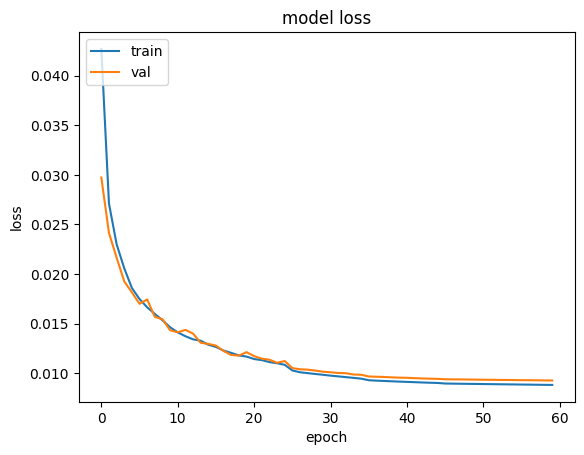

In [15]:
plt.plot(history.history['loss']+history2.history['loss']+history3.history['loss']+history4.history['loss']+history5.history['loss'])
plt.plot(history.history['val_loss']+history2.history['val_loss']+history3.history['val_loss']+history4.history['val_loss']+history5.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [16]:
def plot_reconstruction(set, name,seed_val, epochs):     #name should be either 'training' or 'validation'
  np.random.seed(seed_val)

  tg_indices = np.random.randint(0,set.shape[0],size = 16)
  img_sample = tf.convert_to_tensor(np.array(set)[tg_indices])
  z_sample = encoder(img_sample)
  img_recon = decoder(z_sample)

  recon = plt.figure(figsize=(9,4))
  recon.suptitle('Reconstructed images (right) from the ' + name + '-set after ' + str(epochs) + ' epochs: no regularisation in the encoder, decoder, latent_dim = 512', fontweight= 'bold', y=0.93)

  recon.tight_layout()

  for i in range(36):
    recon.add_subplot(4,9,i+1)
    j = int(np.floor(i/9))
    if (i%9) <4:
      img = set[tg_indices[j*4 + (i%9)]]
      plt.imshow(img)
      plt.axis('off')
    elif (i%9)==4:
      img = np.ones((32,32,3))
      plt.imshow(img)
      plt.axis('off')
    else:
      img = img_recon[j*4 + (i%9) - 5]
      plt.imshow(img)
      plt.axis('off')

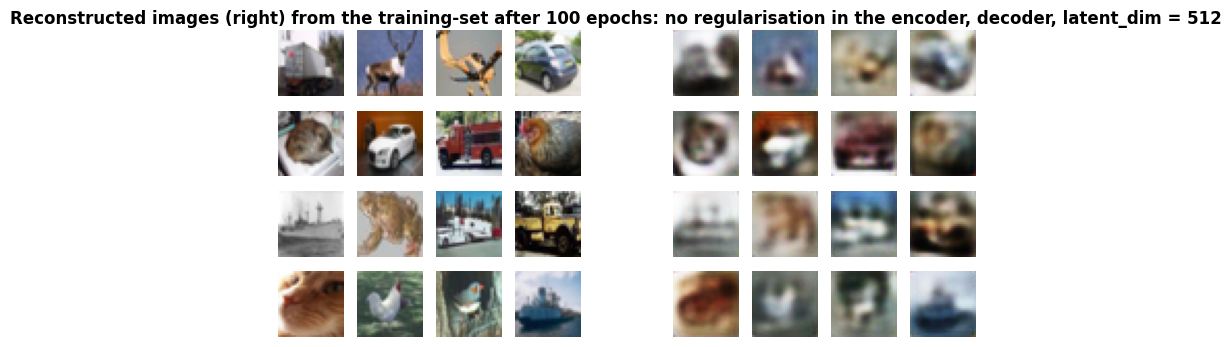

In [17]:
plot_reconstruction(img_train, 'training', 123, 100)

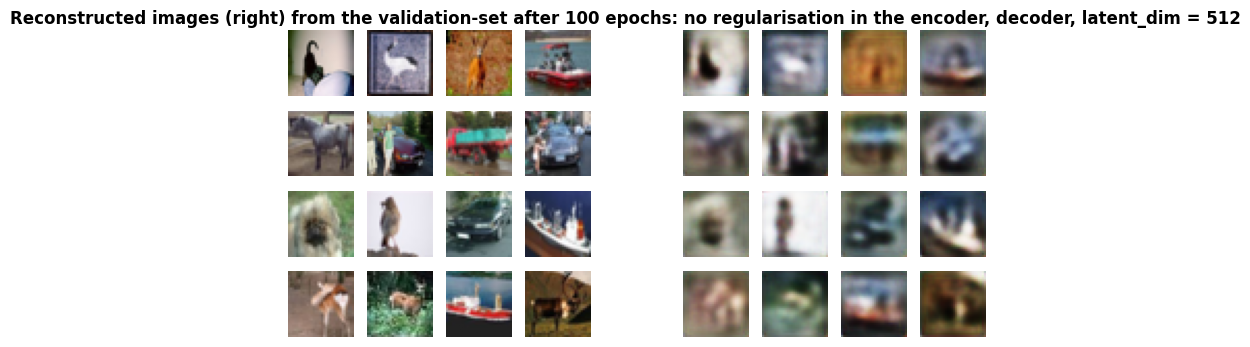

In [18]:
plot_reconstruction(img_valid, 'validation', 123, 100)